# [DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter](https://arxiv.org/abs/1910.01108)

In this lecture, we will explore the architecture of DistilBERT, its key components, and how it can be utilized for various natural language processing tasks. Additionally, we'll discuss its advantages, limitations, and provide hands-on examples to showcase its effectiveness.

Reference : [The Theory](https://towardsdatascience.com/distillation-of-bert-like-models-the-code-73c31e8c2b0a) | [Code](https://towardsdatascience.com/distillation-of-bert-like-models-the-theory-32e19a02641f)

In [1]:
#pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [2]:
#pip install datasets

In [3]:
#pip install transformers

In [4]:
# !pip install datasets --upgrade
import datasets
import transformers
import torch
datasets.__version__, transformers.__version__, torch.__version__

c:\Users\Jue\Desktop\A7\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


('3.4.1', '4.50.0', '2.5.1+cu121')

In [5]:
import torch.nn as nn
import torch
from tqdm.auto import tqdm
import random, math, time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


## 1. Loading our MNLI part of the GLUE dataset

In [6]:
#pip install scikit_learn

In [7]:
from datasets import load_dataset

def get_hate_speech_dataset():
    """Loads the hate_speech_offensive dataset."""
    return load_dataset("hate_speech_offensive")

dataset = get_hate_speech_dataset()

In [8]:
label_list = ["Non-Hate", "Offensive", "Hate"]
label2id = dict(zip(label_list, range(len(label_list))))
id2label = dict(zip(label2id.values(), label2id.keys()))


In [9]:
task_to_keys = {"hatexplain": "tweet"}
task_name = "hatexplain"
sentence_key = task_to_keys.get(task_name, "default_key")

In [10]:
def show_dataset_info(dataset, sentence_key, label2id, id2label):
    print("Dataset Overview:\n", dataset)
    print("Example Sentence:", dataset["train"][0][sentence_key])
    print("Label to ID Mapping:", label2id)
    print("ID to Label Mapping:", id2label)

show_dataset_info(dataset, sentence_key, label2id, id2label)

Dataset Overview:
 DatasetDict({
    train: Dataset({
        features: ['count', 'hate_speech_count', 'offensive_language_count', 'neither_count', 'class', 'tweet'],
        num_rows: 24783
    })
})
Example Sentence: !!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
Label to ID Mapping: {'Non-Hate': 0, 'Offensive': 1, 'Hate': 2}
ID to Label Mapping: {0: 'Non-Hate', 1: 'Offensive', 2: 'Hate'}


## 2. Model & Tokenization

In [11]:
def count_unique_labels(labels):
    return len(labels)

num_labels = count_unique_labels(label_list)
print(f"Unique label count: {num_labels}")

Unique label count: 3


In [12]:
from transformers import AutoTokenizer

teacher_id = "bert-base-uncased"

try:
    tokenizer = AutoTokenizer.from_pretrained(teacher_id)
except Exception as e:
    print(f"Error loading tokenizer for {teacher_id}: {e}")
    tokenizer = None


In [13]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
def load_teacher_model(model_id, num_labels, label2id, id2label):
    return AutoModelForSequenceClassification.from_pretrained(
        model_id,
        num_labels=num_labels,
        id2label=id2label,
        label2id=label2id,
    )

teacher_model = load_teacher_model(teacher_id, num_labels, label2id, id2label)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
tokenize_function = lambda examples: tokenizer(
    examples["tweet"], max_length=128, truncation=True, padding="max_length"
)


In [15]:
tokenized_datasets = dataset.map(lambda x: tokenizer(x["tweet"], max_length=128, truncation=True, padding="max_length"), batched=True)


## 3. Preprocessing 

In [16]:
def preprocess_dataset(dataset, tokenizer):
    dataset = dataset.remove_columns([
        "count", "hate_speech_count", "offensive_language_count", "neither_count", "tweet"
    ])
    dataset = dataset.rename_column("class", "labels")
    dataset.set_format("torch")
    sample_ids = dataset["train"][0]["input_ids"]
    print("Input IDs:", sample_ids)
    print("Decoded text:", tokenizer.decode(sample_ids))
    return dataset

tokenized_datasets = preprocess_dataset(tokenized_datasets, tokenizer)


Input IDs: tensor([  101,   999,   999,   999, 19387,  1030,  9815, 19454, 21818,  2135,
         1024,  2004,  1037,  2450,  2017,  5807,  1005,  1056, 17612,  2055,
         9344,  2039,  2115,  2160,  1012,  1004, 23713,  1025,  2004,  1037,
         2158,  2017,  2323,  2467,  2202,  1996, 11669,  2041,  1012,  1012,
         1012,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,    

## 4. Preparing the dataloader

In [17]:
from transformers import DataCollatorWithPadding
def create_data_collator(tokenizer):
    return DataCollatorWithPadding(tokenizer=tokenizer)

data_collator = create_data_collator(tokenizer)


In [18]:
subset_sizes = {"train": 10_000, "eval": 1_000, "test": 1_000}
shuffled = tokenized_datasets["train"].shuffle(seed=1150)

small_train_dataset = shuffled.select(range(subset_sizes["train"]))
small_eval_dataset = shuffled.select(range(subset_sizes["eval"]))
small_test_dataset = shuffled.select(range(subset_sizes["test"]))


In [19]:
from torch.utils.data import DataLoader
def create_dataloader(dataset, batch_size=32, shuffle=False, collator=None):
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=collator)

train_dataloader = create_dataloader(small_train_dataset, shuffle=True, collator=data_collator)
eval_dataloader  = create_dataloader(small_eval_dataset, collator=data_collator)
test_dataloader  = create_dataloader(small_test_dataset, collator=data_collator)


In [20]:
batch = next(iter(train_dataloader))
batch['labels'].shape, batch['input_ids'].shape, batch['attention_mask'].shape


(torch.Size([32]), torch.Size([32, 128]), torch.Size([32, 128]))

## 5. Design the model and losses

### 5.1 Teacher Model & Student Model

####  Architecture 
In the present work, the student - DistilBERT - has the same general architecture as BERT. 
- The `token-type embeddings` and the `pooler` are removed while `the number of layers` is reduced by a factor of 2. 
- Most of the operations used in the Transformer architecture `linear layer` and `layer normalisation` are highly optimized in modern linear algebra frameworks.
- our investigations showed that variations on the last dimension of the tensor (hidden size dimension) have a smaller impact on computation efficiency (for a fixed parameters budget) than variations on other factors like the number of layers. 
- Thus we focus on reducing the number of layers.

#### Initialize Student Model
- To initialize a new model from an existing one, we need to access the weights of the old model (the teacher). 
- In order to get the weights, we first have to know how to access them. We’ll use BERT as our teacher model.

In [21]:
#pip install evaluate

In [22]:
import torch.optim as optim
import torch.nn.functional as F
from transformers.models.bert.modeling_bert import BertModel, BertPreTrainedModel, BertConfig
from tqdm.auto import tqdm
import evaluate

In [23]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

configuration = teacher_model.config.to_dict()


Using GPU


#### 
- The student model has the same configuration, except the number of layers is reduced by a factor of 2
- The student layers are initilized by copying one out of two layers of the teacher, starting with layer 0.
- The head of the teacher is also copied.

In [24]:
def create_student_config(base_config, num_layers=6):
    config_dict = base_config.to_dict()
    config_dict["num_hidden_layers"] = num_layers
    return BertConfig.from_dict(config_dict)

configuration = create_student_config(teacher_model.config, num_layers=6)


In [25]:
def create_student_model(config):
    return type(teacher_model)(config)

student_model_odd = create_student_model(configuration)
student_model_even = create_student_model(configuration)


In [26]:
student_model_odd

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

- Recursively copies the weights of the (teacher) to the (student).
- This function is meant to be first called on a BertFor... model, but is then called on every children of that model recursively.
- The only part that's not fully copied is the encoder, of which only half is copied.

In [27]:
def copy_selected_encoder_layers(teacher_layers, student_layers, layer_type):
    indices = range(0, 12, 2) if layer_type == "odd" else range(1, 12, 2)
    for i, idx in enumerate(indices):
        student_layers[i].load_state_dict(teacher_layers[idx].state_dict())

def distill(teacher, student, layer_type="odd"):
    if hasattr(teacher, "encoder") and hasattr(student, "encoder"):
        copy_selected_encoder_layers(list(teacher.encoder.layer), list(student.encoder.layer), layer_type)

    if hasattr(teacher, "pooler") and hasattr(student, "pooler"):
        student.pooler.load_state_dict(teacher.pooler.state_dict())

    return student

In [28]:
def distill_models(teacher, students, types):
    return [distill(teacher, student, t) for student, t in zip(students, types)]

student_model_odd, student_model_even = distill_models(
    teacher_model,
    [student_model_odd, student_model_even],
    ["odd", "even"]
)


In [29]:
# Move models to device
student_model_odd = student_model_odd.to(device)
student_model_even = student_model_even.to(device)
teacher_model = teacher_model.to(device)

In [30]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

models = {
    "Teacher": teacher_model,
    "Odd Student": student_model_odd,
    "Even Student": student_model_even
}

teacher_count = count_parameters(models["Teacher"])

for name, model in models.items():
    count = count_parameters(model)
    percentage = (count / teacher_count) * 100
    print(f"{name} parameters: {count:,} ({percentage:.2f}%)")


Teacher parameters: 109,484,547 (100.00%)
Odd Student parameters: 66,957,315 (61.16%)
Even Student parameters: 66,957,315 (61.16%)


### 5.2 Loss function

#### Softmax

$$
P_i(\mathbf{z}_i, T) = \frac{\exp(\mathbf{z}_i / T)}{\sum_{q=0}^k \exp(\mathbf{z}_q / T)}
$$


#### Knowledge Distillation

#### CE Loss
$$\mathcal{L}_\text{CE} = -\sum^N_{j=0}\sum_{i=0}^k {y}_i^{(j)}\log(P_i({v}_i^{(j)}, 1))$$

#### KL Loss
$$\mathcal{L}_\text{KD} = -\sum^N_{j=0}\sum_{i=0}^k P_i({z}_i^{(j)}, T) \log (P_i({v}_i^{(j)}, T))$$

#### Cosine Embedding Loss
$$\mathcal{L}_{\text{cosine}}(x_1, x_2, y) = \frac{1}{N} \sum_{i=1}^{N} \left(1 - y_i \cdot \cos(\theta_i)\right)$$

<!-- $$\mathcal{L} = \lambda \mathcal{L}_\text{KD} + (1-\lambda)\mathcal{L}_\text{CE}$$
 -->

#### Total Loss
$$\mathcal{L} = \mathcal{L}_\text{KD} + \mathcal{L}_\text{CE} + \mathcal{L}_{\text{cosine}}$$

In [31]:
class Distill_kl_loss(nn.Module):
    def __init__(self):
        super().__init__()
        self.kl_div = nn.KLDivLoss(reduction='batchmean')

    def forward(self, student_logits, teacher_logits, temperature=1.0):
        T = temperature
        return self.kl_div(
            F.log_softmax(student_logits / T, dim=-1),
            F.softmax(teacher_logits / T, dim=-1)
        ) * (T * T)


In [32]:
loss_functions = {
    "classification": nn.CrossEntropyLoss(),
    "distillation": Distill_kl_loss(),
    "cosine": nn.CosineEmbeddingLoss()
}

criterion_cls = loss_functions["classification"]
criterion_div = loss_functions["distillation"]
criterion_cos = loss_functions["cosine"]


## 6. Optimizer

In [33]:
def create_optimizer(model, lr=5e-5):
    return optim.Adam(model.parameters(), lr=lr)

optimizer_odd = create_optimizer(student_model_odd)
optimizer_even = create_optimizer(student_model_even)

num_epochs = 5
num_training_steps = num_epochs * len(train_dataloader)



## 7. Learning rate scheduler

In [34]:
from transformers import get_scheduler
def create_scheduler(optimizer, total_steps, warmup_steps=0, schedule_type="linear"):
    return get_scheduler(
        name=schedule_type,
        optimizer=optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps
    )

lr_scheduler_odd = create_scheduler(optimizer_odd, num_training_steps)
lr_scheduler_even = create_scheduler(optimizer_even, num_training_steps)


## 8. Metric

In [35]:
# !pip3 install evaluate

In [36]:
def load_metric(name="accuracy"):
    return evaluate.load(name)

metric = load_metric()


## 9. Train

In [37]:
def compute_losses(student_logits, teacher_logits, labels):
    loss_cls = criterion_cls(student_logits, labels)
    loss_div = criterion_div(student_logits, teacher_logits)
    cos_target = torch.ones(teacher_logits.size(0)).to(device)
    loss_cos = criterion_cos(teacher_logits, student_logits, cos_target)
    total_loss = (loss_cls + loss_div + loss_cos) / 3
    return total_loss, loss_cls, loss_div, loss_cos

def evaluate_model(model):
    model.eval()
    total_loss = 0
    metric = evaluate.load("accuracy")  # ✅ FIX: reinitialize per call (no .reset() needed)

    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        loss = criterion_cls(outputs.logits, batch["labels"])
        total_loss += loss.item()
        preds = outputs.logits.argmax(dim=-1)
        metric.add_batch(predictions=preds, references=batch["labels"])

    eval_metric = metric.compute()
    avg_loss = total_loss / len(eval_dataloader)
    return eval_metric["accuracy"], avg_loss

def train_student_model(student_model, optimizer, lr_scheduler, student_type="odd"):
    progress_bar = tqdm(range(num_training_steps))
    eval_scores = 0

    train_losses, train_losses_cls, train_losses_div, train_losses_cos, eval_losses = [], [], [], [], []

    for epoch in range(num_epochs):
        student_model.train()
        teacher_model.eval()

        epoch_loss, epoch_cls, epoch_div, epoch_cos = 0, 0, 0, 0

        for batch in train_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}

            student_output = student_model(**batch)
            with torch.no_grad():
                teacher_output = teacher_model(**batch)

            loss, loss_cls, loss_div, loss_cos = compute_losses(
                student_output.logits, teacher_output.logits, batch["labels"]
            )

            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            # Track losses
            epoch_loss += loss.item()
            epoch_cls += loss_cls.item()
            epoch_div += loss_div.item()
            epoch_cos += loss_cos.item()
            progress_bar.update(1)

        # Store average epoch losses
        train_losses.append(epoch_loss / len(train_dataloader))
        train_losses_cls.append(epoch_cls / len(train_dataloader))
        train_losses_div.append(epoch_div / len(train_dataloader))
        train_losses_cos.append(epoch_cos / len(train_dataloader))

        print(f"Epoch {epoch+1} ({student_type} student):")
        print(f"  Train Loss: {epoch_loss / len(train_dataloader):.4f}")
        print(f"    - cls: {epoch_cls / len(train_dataloader):.4f}")
        print(f"    - div: {epoch_div / len(train_dataloader):.4f}")
        print(f"    - cos: {epoch_cos / len(train_dataloader):.4f}")

        # Evaluation
        accuracy, eval_loss = evaluate_model(student_model)
        eval_scores += accuracy
        eval_losses.append(eval_loss)
        print(f"  Eval Accuracy: {accuracy:.4f}  |  Eval Loss: {eval_loss:.4f}")

    print(f"\nAverage Accuracy ({student_type} student): {eval_scores / num_epochs:.4f}")


In [38]:
students = {
    "odd": (student_model_odd, optimizer_odd, lr_scheduler_odd),
    "even": (student_model_even, optimizer_even, lr_scheduler_even),
}

for name, (model, optimizer, scheduler) in students.items():
    print(f"\n=== Training {name.capitalize()}-Layer Student Model ===")
    train_student_model(model, optimizer, scheduler, student_type=name)



=== Training Odd-Layer Student Model ===


 20%|██        | 313/1565 [14:23<42:59,  2.06s/it]  

Epoch 1 (odd student):
  Train Loss: 0.3404
    - cls: 0.7221
    - div: 0.1392
    - cos: 0.1597
  Eval Accuracy: 0.8660  |  Eval Loss: 0.5989


 40%|████      | 626/1565 [28:48<31:44,  2.03s/it]  

Epoch 2 (odd student):
  Train Loss: 0.3088
    - cls: 0.5925
    - div: 0.1738
    - cos: 0.1603
  Eval Accuracy: 0.9120  |  Eval Loss: 0.5322


 60%|██████    | 939/1565 [43:31<21:20,  2.05s/it]

Epoch 3 (odd student):
  Train Loss: 0.3004
    - cls: 0.5573
    - div: 0.1833
    - cos: 0.1607
  Eval Accuracy: 0.9310  |  Eval Loss: 0.5190


 80%|████████  | 1252/1565 [57:56<10:29,  2.01s/it]

Epoch 4 (odd student):
  Train Loss: 0.2934
    - cls: 0.5274
    - div: 0.1921
    - cos: 0.1607
  Eval Accuracy: 0.9530  |  Eval Loss: 0.4949


100%|██████████| 1565/1565 [1:12:17<00:00,  2.04s/it]

Epoch 5 (odd student):
  Train Loss: 0.2872
    - cls: 0.5023
    - div: 0.1988
    - cos: 0.1605


100%|██████████| 1565/1565 [1:12:22<00:00,  2.77s/it]


  Eval Accuracy: 0.9560  |  Eval Loss: 0.4854

Average Accuracy (odd student): 0.9236

=== Training Even-Layer Student Model ===


 20%|██        | 313/1565 [08:33<25:54,  1.24s/it]

Epoch 1 (even student):
  Train Loss: 0.3410
    - cls: 0.7303
    - div: 0.1349
    - cos: 0.1579
  Eval Accuracy: 0.8560  |  Eval Loss: 0.6424


 40%|████      | 626/1565 [17:15<19:31,  1.25s/it]  

Epoch 2 (even student):
  Train Loss: 0.3089
    - cls: 0.5939
    - div: 0.1738
    - cos: 0.1590
  Eval Accuracy: 0.8970  |  Eval Loss: 0.5818


 60%|██████    | 939/1565 [25:57<13:04,  1.25s/it]

Epoch 3 (even student):
  Train Loss: 0.3008
    - cls: 0.5570
    - div: 0.1860
    - cos: 0.1595
  Eval Accuracy: 0.9300  |  Eval Loss: 0.5158


 80%|████████  | 1252/1565 [34:43<06:33,  1.26s/it]

Epoch 4 (even student):
  Train Loss: 0.2928
    - cls: 0.5240
    - div: 0.1944
    - cos: 0.1599
  Eval Accuracy: 0.9510  |  Eval Loss: 0.5090


100%|██████████| 1565/1565 [43:27<00:00,  1.25s/it]

Epoch 5 (even student):
  Train Loss: 0.2875
    - cls: 0.5030
    - div: 0.1996
    - cos: 0.1598


100%|██████████| 1565/1565 [43:32<00:00,  1.67s/it]

  Eval Accuracy: 0.9590  |  Eval Loss: 0.4750

Average Accuracy (even student): 0.9186


In [40]:
pip install matplotlib

   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.1 MB 2.8 MB/s eta 0:00:03
   --- ------------------------------------ 0.8/8.1 MB 2.4 MB/s eta 0:00:04
   ------ --------------------------------- 1.3/8.1 MB 2.0 MB/s eta 0:00:04
   ------ --------------------------------- 1.3/8.1 MB 2.0 MB/s eta 0:00:04
   ------- -------------------------------- 1.6/8.1 MB 1.6 MB/s eta 0:00:05
   ------- -------------------------------- 1.6/8.1 MB 1.6 MB/s eta 0:00:05
   --------- ------------------------------ 1.8/8.1 MB 1.3 MB/s eta 0:00:05
   --------- ------------------------------ 1.8/8.1 MB 1.3 MB/s eta 0:00:05
   ---------- ----------------------------- 2.1/8.1 MB 1.1 MB/s eta 0:00:06
   ---------- ----------------------------- 2.1/8.1 MB 1.1 MB/s eta 0:00:06
   ----------- ---------------------------- 2.4/8.1 MB 1.0 MB/s eta 0:00:06
   ----------- ---------------------------- 2.4/8.1 MB 1.0 MB/s eta 0:00:06
   ------------- --

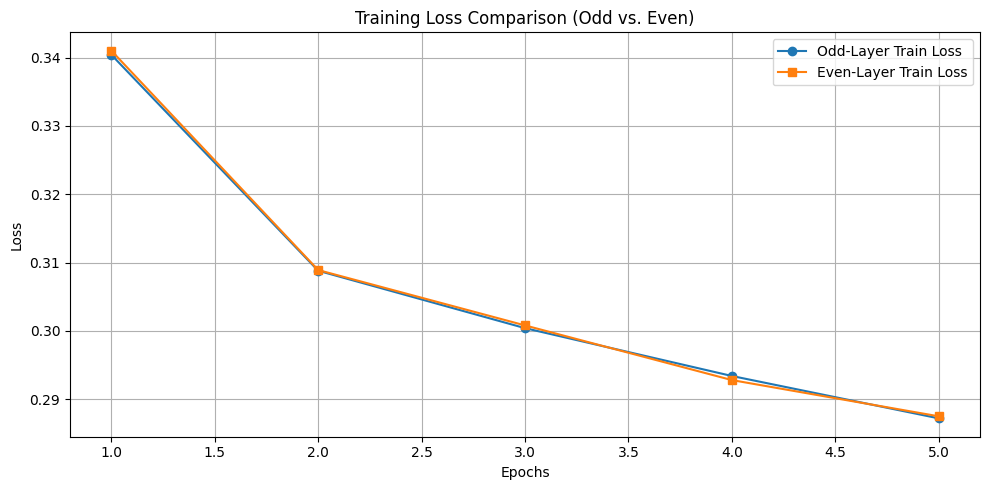

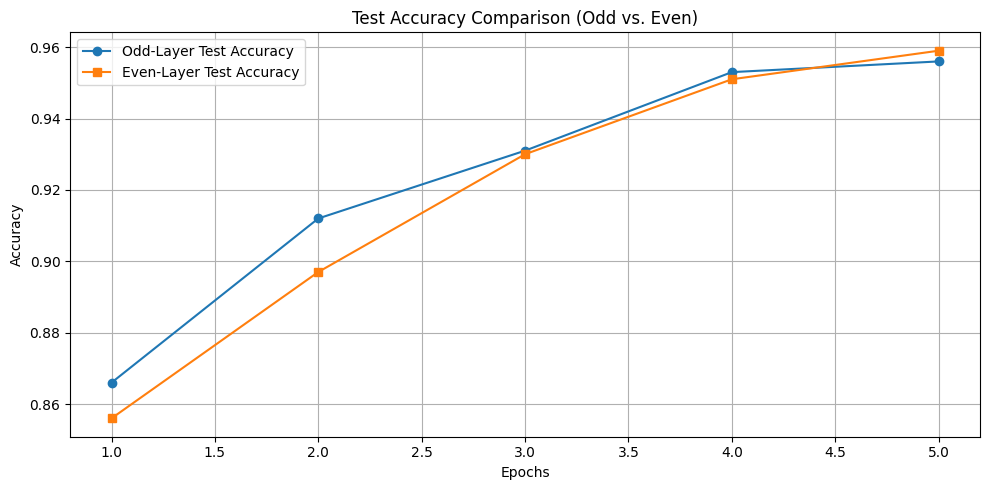

In [41]:
import matplotlib.pyplot as plt

# Epoch range (1 to 4)
epochs = list(range(1, 6))

# Updated values
odd_train_loss = [0.3404, 0.3088, 0.3004, 0.2934, 0.2872]
even_train_loss = [0.3410, 0.3089, 0.3008, 0.2928, 0.2875]

odd_test_acc = [0.8660, 0.9120, 0.9310, 0.9530, 0.9560]
even_test_acc = [0.8560, 0.8970, 0.9300, 0.9510, 0.9590]

# Plot Training Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, odd_train_loss, label="Odd-Layer Train Loss", marker="o")
plt.plot(epochs, even_train_loss, label="Even-Layer Train Loss", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Comparison (Odd vs. Even)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Test Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, odd_test_acc, label="Odd-Layer Test Accuracy", marker="o")
plt.plot(epochs, even_test_acc, label="Even-Layer Test Accuracy", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Test Accuracy Comparison (Odd vs. Even)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# LORA with Student Model

In [42]:
pip install peft

  Using cached accelerate-1.5.2-py3-none-any.whl.metadata (19 kB)
Using cached accelerate-1.5.2-py3-none-any.whl (345 kB)
Note: you may need to restart the kernel to use updated packages.


In [43]:
from peft import get_peft_model, LoraConfig, TaskType
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_name = "bert-base-uncased"
num_classes = 3

student_model_lora = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_classes
)
student_model_lora.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [44]:
def get_lora_config():
    return LoraConfig(
        task_type=TaskType.SEQ_CLS,
        r=8,
        lora_alpha=16,
        lora_dropout=0.1,
        target_modules=["query", "value"]
    )

lora_config = get_lora_config()

In [45]:
def apply_lora(model, config):
    model = get_peft_model(model, config)
    model.print_trainable_parameters()
    return model

student_model_lora = apply_lora(student_model_lora, lora_config)


trainable params: 297,219 || all params: 109,781,766 || trainable%: 0.2707


In [46]:
def get_loss_fn():
    return nn.CrossEntropyLoss()

criterion = get_loss_fn()

## Optimizer,Learning rate scheduler & Metric

In [47]:
def create_optimizer(model, lr=5e-5):
    return optim.Adam(model.parameters(), lr=lr)

def create_scheduler(optimizer, epochs, dataloader, warmup=0):
    total_steps = epochs * len(dataloader)
    return get_scheduler("linear", optimizer=optimizer, num_warmup_steps=warmup, num_training_steps=total_steps)

optimizer_lora = create_optimizer(student_model_lora)
lr_scheduler_lora = create_scheduler(optimizer_lora, num_epochs, train_dataloader)

metric = evaluate.load("accuracy")

## Train

In [48]:
from tqdm.auto import tqdm

# Training loop
progress_bar = tqdm(range(num_training_steps))
best_accuracy = 0

for epoch in range(num_epochs):
    student_model_lora.train()
    total_loss = 0

    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        
        # Forward pass
        outputs = student_model_lora(**batch)
        loss = criterion(outputs.logits, batch["labels"])
        
        # Backward pass
        optimizer_lora.zero_grad()
        loss.backward()
        optimizer_lora.step()
        lr_scheduler_lora.step()
        
        total_loss += loss.item()
        progress_bar.update(1)

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"\nEpoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f}")

    # Evaluation
    student_model_lora.eval()
    eval_loss = 0
    metric = evaluate.load("accuracy")  # Fresh instance per epoch

    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = student_model_lora(**batch)
        loss = criterion(outputs.logits, batch["labels"])
        predictions = outputs.logits.argmax(dim=-1)
        
        eval_loss += loss.item()
        metric.add_batch(predictions=predictions, references=batch["labels"])

    avg_eval_loss = eval_loss / len(eval_dataloader)
    eval_accuracy = metric.compute()["accuracy"]
    print(f"Epoch {epoch+1}/{num_epochs} | Eval Loss: {avg_eval_loss:.4f} | Eval Accuracy: {eval_accuracy:.4f}")

    # Save best model
    if eval_accuracy > best_accuracy:
        best_accuracy = eval_accuracy
        best_model_state = student_model_lora.state_dict()

# Optional: save best model
torch.save(best_model_state, "lora_student_best.pt")
print(f"\nBest Eval Accuracy: {best_accuracy:.4f} — Model saved to 'lora_student_best.pt'")

 20%|██        | 313/1565 [09:40<29:10,  1.40s/it]


Epoch 1/5 | Train Loss: 0.6851
Epoch 1/5 | Eval Loss: 0.5914 | Eval Accuracy: 0.7800


 40%|████      | 626/1565 [19:25<22:10,  1.42s/it]  


Epoch 2/5 | Train Loss: 0.4895
Epoch 2/5 | Eval Loss: 0.3673 | Eval Accuracy: 0.8800


 60%|██████    | 939/1565 [29:16<14:38,  1.40s/it]  


Epoch 3/5 | Train Loss: 0.3853
Epoch 3/5 | Eval Loss: 0.3398 | Eval Accuracy: 0.8890


 80%|████████  | 1252/1565 [39:07<08:10,  1.57s/it] 


Epoch 4/5 | Train Loss: 0.3668
Epoch 4/5 | Eval Loss: 0.3291 | Eval Accuracy: 0.8920


100%|██████████| 1565/1565 [49:01<00:00,  1.38s/it]


Epoch 5/5 | Train Loss: 0.3561
Epoch 5/5 | Eval Loss: 0.3247 | Eval Accuracy: 0.8980

Best Eval Accuracy: 0.8980 — Model saved to 'lora_student_best.pt'


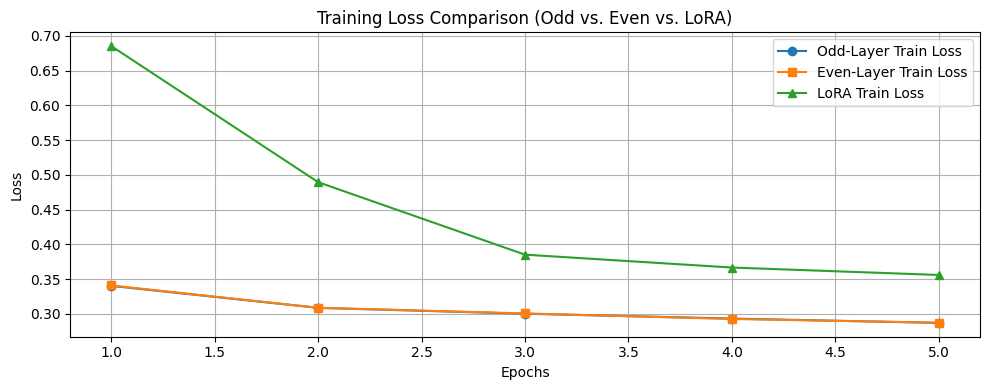

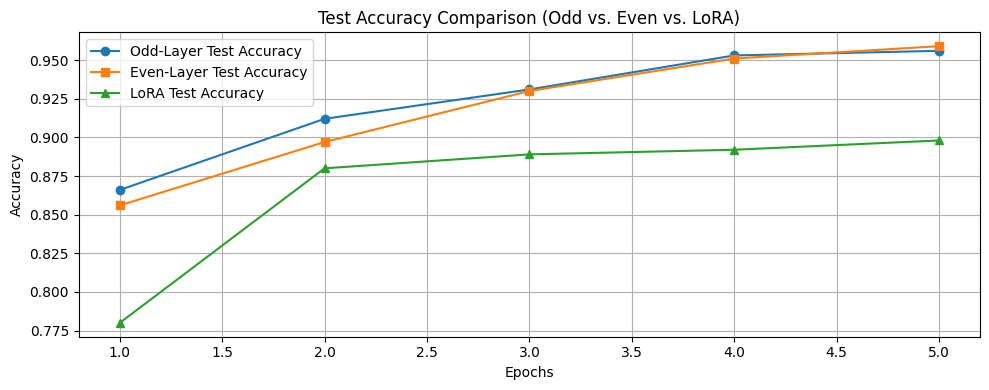

In [43]:
import matplotlib.pyplot as plt

epochs = [1, 2, 3, 4, 5]

# Updated LoRA data
lora_train_loss = [0.6851, 0.4895, 0.3853, 0.3668, 0.3561]
lora_test_acc   = [0.7800, 0.8800, 0.8890, 0.8920, 0.8980]

# Training Loss Plot
plt.figure(figsize=(10, 4))
plt.plot(epochs, [0.3404, 0.3088, 0.3004, 0.2934, 0.2872], label="Odd-Layer Train Loss", marker="o")
plt.plot(epochs, [0.3410, 0.3089, 0.3008, 0.2928, 0.2875], label="Even-Layer Train Loss", marker="s")
plt.plot(epochs, lora_train_loss, label="LoRA Train Loss", marker="^")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Comparison (Odd vs. Even vs. LoRA)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Test Accuracy Plot
plt.figure(figsize=(10, 4))
plt.plot(epochs, [0.8660, 0.9120, 0.9310, 0.9530, 0.9560], label="Odd-Layer Test Accuracy", marker="o")
plt.plot(epochs, [0.8560, 0.8970, 0.9300, 0.9510, 0.9590], label="Even-Layer Test Accuracy", marker="s")
plt.plot(epochs, lora_test_acc, label="LoRA Test Accuracy", marker="^")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Test Accuracy Comparison (Odd vs. Even vs. LoRA)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Evaluation of three models

In [51]:
def evaluate_model(model, model_name):
    model.eval()
    metric = evaluate.load("accuracy")

    with torch.no_grad():
        for batch in test_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            output = model(**batch)
            pred = output.logits.argmax(dim=-1)
            metric.add_batch(predictions=pred, references=batch["labels"])

    result = metric.compute()
    print(f"{model_name} Accuracy: {result['accuracy']:.4f}")
    return result



In [52]:
class ModelSaver:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer

    def save(self, path):
        self.model.save_pretrained(path)
        self.tokenizer.save_pretrained(path)
        print(f"Model saved to {path}")

saver = ModelSaver(student_model_odd, tokenizer)
saver.save("best_model_odd_student")


Model saved to best_model_odd_student


### Appendix (Teacher Model)

In [ ]:
import torch
from tqdm.auto import tqdm
import torch.optim as optim
import torch.nn as nn

lr = 5e-5
#training hyperparameters
optimizer = optim.Adam(params=teacher_model.parameters(), lr=lr)

progress_bar = tqdm(range(num_training_steps))
eval_metrics = 0

for epoch in range(num_epochs):
    teacher_model.train()
    train_loss = 0
    for step, batch in enumerate(train_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        output_teacher = teacher_model(**batch)
        # cls loss 
        loss = output_teacher.loss
        train_loss += loss.item()
        loss.backward()
        # accelerator.backward(loss)
        # Step with optimizer
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    print(f'Epoch at {epoch+1}: Train loss {train_loss/len(train_dataloader):.4f}:')
    
    teacher_model.eval()
    for step, batch in enumerate(eval_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = teacher_model(**batch)
    
        predictions = outputs.logits.argmax(dim=-1)
        # predictions, references = accelerator.gather((predictions, batch["labels"]))
        metric.add_batch(
            predictions=predictions, 
            references=batch["labels"])
        
    eval_metric = metric.compute()
    eval_metrics += eval_metric['accuracy'] 
    print(f"Epoch at {epoch+1}: Test Acc {eval_metric['accuracy']:.4f}")
    
print('Avg Metric', eval_metrics/num_epochs)